In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_timestamp_true =[]
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_timestamp_true, scaler_x, scaler_y, scaler_time


In [6]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, test_timestamp_orig, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

In [7]:
n = 99
x_train_full = jnp.concatenate((x_train.reshape(-1,n), jnp.array(np.array(x_train_timstamp))), axis=1)
x_test_full = jnp.concatenate((x_test.reshape(-1,n), jnp.array(np.array(x_test_timestamp))), axis=1)
x_train_full.shape, x_test_full.shape

((53456, 100), (16781, 100))

In [8]:
x_train.reshape(-1,n).shape, x_test.reshape(-1,n).shape, y_train.shape, y_test.shape

((53456, 99), (16781, 99), (53456, 1), (16781, 1))

In [9]:
# x = x_train_full[:14000]
# y = y_train[:14000]
# xt = x_train_full[14000:]
# yt = y_train[14000:]

In [10]:
# x.shape, y.shape

In [11]:
import gpytorch
indexes = 53456
x = torch.tensor(np.array(x_train.reshape(-1,n))).to(torch.float64)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test.reshape(-1,n))).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)

if x.shape[0]>indexes:
  x1 = x[:indexes]
  y1 = y[:indexes]

# xt = xt[:16000]
# yt = yt[:16000]

In [12]:
x.dtype

torch.float64

In [13]:
x.shape, y.shape, xt.shape, yt.shape

(torch.Size([53456, 99]),
 torch.Size([53456]),
 torch.Size([16781, 99]),
 torch.Size([16781]))

In [14]:
x.dtype

torch.float64

In [15]:
len(range(99))

99

restart: 0, epoch: 1, iter: 1, loss: 1.4718
restart: 0, epoch: 2, iter: 1, loss: 1.4690
restart: 0, epoch: 3, iter: 1, loss: 1.4661
restart: 0, epoch: 4, iter: 1, loss: 1.4634
restart: 0, epoch: 5, iter: 1, loss: 1.4608
restart: 0, epoch: 6, iter: 1, loss: 1.4584
restart: 0, epoch: 7, iter: 1, loss: 1.4560
restart: 0, epoch: 8, iter: 1, loss: 1.4538
restart: 0, epoch: 9, iter: 1, loss: 1.4517
restart: 0, epoch: 10, iter: 1, loss: 1.4497
restart: 0, epoch: 11, iter: 1, loss: 1.4477
restart: 0, epoch: 12, iter: 1, loss: 1.4458
restart: 0, epoch: 13, iter: 1, loss: 1.4440
restart: 0, epoch: 14, iter: 1, loss: 1.4422
restart: 0, epoch: 15, iter: 1, loss: 1.4405
restart: 0, epoch: 16, iter: 1, loss: 1.4388
restart: 0, epoch: 17, iter: 1, loss: 1.4372
restart: 0, epoch: 18, iter: 1, loss: 1.4356
restart: 0, epoch: 19, iter: 1, loss: 1.4340
restart: 0, epoch: 20, iter: 1, loss: 1.4325
restart: 0, epoch: 21, iter: 1, loss: 1.4310
restart: 0, epoch: 22, iter: 1, loss: 1.4295
restart: 0, epoch: 

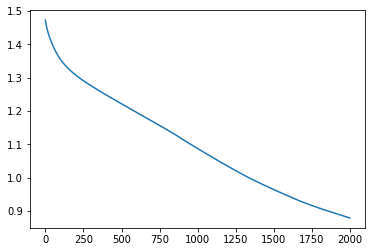

In [40]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

# y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(1):


   #nu=2.5,

  kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
  # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
  kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(99)))
  # kernel5 = ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(num_dims=n,ard_num_dims=n))
#   theta =  {'base_covar_module.kernels.0.base_kernel.lengthscale': torch.tensor(0.5),
#         'base_covar_module.kernels.0.outputscale': torch.tensor(5.0),
#         'base_covar_module.kernels.1.kernels.0.outputscale':torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.0.base_kernel.lengthscale': torch.tensor(0.1),
#         'base_covar_module.kernels.1.kernels.1.outputscale':torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.1.base_kernel.lengthscale': torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
  # theta = { 'base_covar_module.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
  # kernel4 = kernel2*kernel3
  kernel = kernel1 #+ kernel3
  # induce_points = 512
  inducing_points =  x[np.arange(0,x.shape[0],95)] 
  # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]
  
  model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.base_covar_module.base_kernel.raw_lengthscale_constraint
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss = model.fit(lr=0.001, n_epochs=2000,verbose=1,
          random_state=0, n_restarts=1)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))







  # y_pred_arr.append(pred_dist.loc)

  

In [43]:
  model_name = "Refrigerator_trial_seq_time.pt"
  torch.save(model.state_dict(), os.path.join(
   "models/", model_name))


## Decomp

In [18]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
# kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(99)))

# kernel4 = kernel2*kernel3
kernel = kernel1 #ernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],70)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_rbf_building6_" + str(0) + ".pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

<All keys matched successfully>

In [27]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [28]:
pred_dist1 = model1.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [29]:
y_mean1.shape

torch.Size([4000])

In [30]:
pred_arr =[]
pred_arr.append(np.array(pred_dist1.mean.cpu()))

In [31]:
y_mean = np.mean(pred_arr, axis =0)

# y_Std = np.std(np.array(pred_arr), axis =0)

In [37]:
y_mean.shape, y_Std.shape

((4000,), (4000,))

In [32]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
# y_std = scaler_y.inverse_transform(y_Std.reshape(-1,1)).squeeze()

In [28]:
y_mean.shape

(16781,)

In [48]:
y_mean.any() < 0

False

In [33]:
y_mean_ = np.clip(y_mean,0,y_mean.max())
# y_sigma =  np.clip(y_mean,0,y_mean.max())

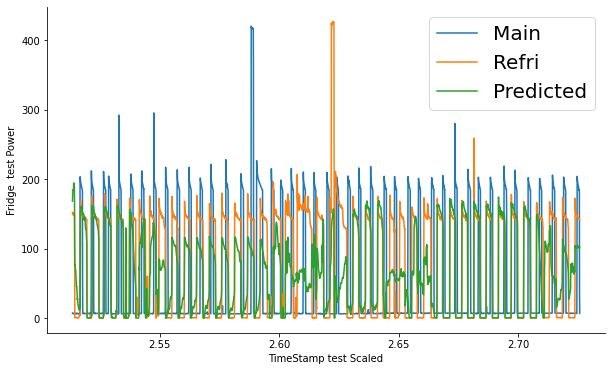

In [34]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_x.inverse_transform(xt.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], yt.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean_[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()
# savefig("Uncertainity")

In [35]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                      inducing_points).to("cuda")

In [36]:
pred_dist2 = model2.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

In [37]:
y_mean = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([16781]) (4000,)


In [38]:
y_mean_ = np.clip(y_mean,0,y_mean.max())

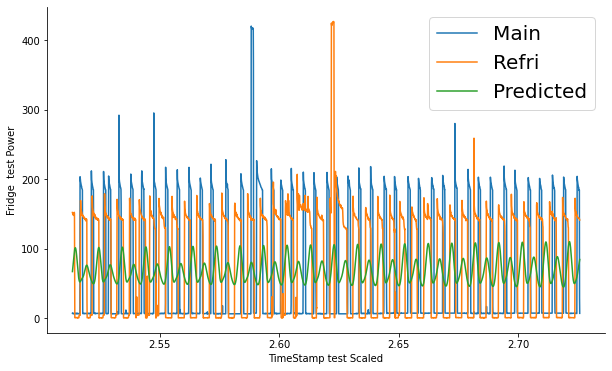

In [39]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_y.inverse_transform(y.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], yt.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean_[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

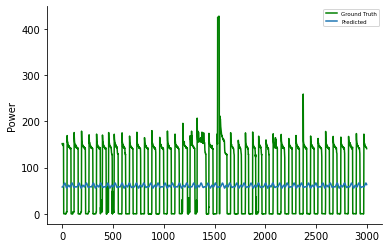

In [42]:
idx = 3000
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx),  yt.cpu().reshape(-1,1)[:idx], label = "Ground Truth", color="green")
plt.plot(jnp.arange(idx), y_mean_[:idx].reshape(-1,1), label = "Predicted")
# for i in range(2,3):
#     plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_std[:idx], y_mean[:idx] + i*y_std[:idx],
#                     color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.legend( prop={'size': 5.5})
plt.ylabel("Power")
sns.despine()

In [22]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  27.80521506352558
RMSE:  44.84471


In [59]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled


In [60]:
os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Final_plotss/"

In [62]:
latexify(width_scale_factor=2, fig_height=2)

In [22]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean[300:idx+300], label = "Fridge Predicted")
plt.legend()
sns.despine()
savefig("CombinationKernel")

saving image to ./Final_plotss/CombinationKernel_latexified.pdf
Figure size: [2. 2.]


In [23]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                       inducing_points).to("cuda")

In [24]:
pred_dist1 = model1.predict(xt.to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [25]:
y_mean1 = scaler_y.inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean1.shape)

torch.Size([14780]) (14780,)


In [26]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean1[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFKernel")

saving image to ./Final_plotss/RBFKernel_latexified.pdf
Figure size: [2. 2.]


In [ ]:
# for name, params in model.named_parameters():
#   print(name, params)

# # model.mll.model.base_covar_module.kernels.base_kernel.raw_lengthscale

In [19]:
x.shape

torch.Size([55457, 100])

In [22]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                       inducing_points).to("cuda")

In [23]:
pred_dist2 = model2.predict(xt.to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [24]:
y_mean2 = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean2.shape)

torch.Size([14780]) (14780,)


In [26]:
idx = 2000
plt.figure()
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean2[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFxPeriodicKernel")

saving image to ./Final_plotss/RBFxPeriodicKernel_latexified.pdf
Figure size: [2. 2.]


## Normal

In [16]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
# kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(99)))

# kernel4 = kernel2*kernel3
kernel = kernel1# + kernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],95)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_trial_seq_time.pt"
model.load_state_dict(torch.load(
    os.path.join("models/", model_name)))

<All keys matched successfully>

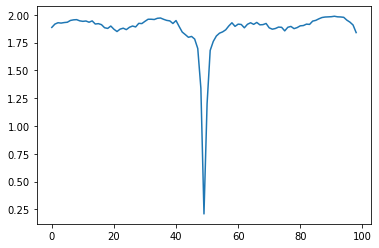

In [41]:
plt.plot(range(99),model.mll.model.base_covar_module.base_kernel.lengthscale.cpu().detach().reshape(-1,1))

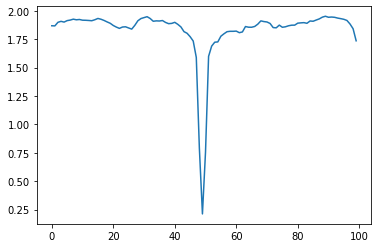

In [37]:
plt.plot(range(100),model.mll.model.base_covar_module.kernels[0].base_kernel.lengthscale.cpu().detach().reshape(-1,1))

In [33]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-1.0096], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.0197], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-1.5955, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[ 1.7127,  1.7136,  1.7333,  1.7442,  1.7402,  1.7397,  1.7466,  1.7686,
          1.7576,  1.7448,  1.7657,  1.7839,  1.7661,  1.7749,  1.7550,  1.7648,
          1.7573,  1.7221,  1.7115,  1.7185,  1.6733,  1.6714,  1.6615,  1.6700,
          1.6799,  1.6863,  1.7105,  1.7212,  1.7603,  1.7713,  1.7818,  1.7861,
          1.7688,  1.7527,  1.7599,  1.7722,  1.7489,  1.7463,  1.7318,  1.7100,
          1.7155,  1.6706,  1.6410,  1.5965,  1.5681,  1.6244,  1.5938,  1.4162,
          0.2203, -1.4909,  0.0535,  1.4510,  1.5215,  1.5698,  1.6006,  1.6280,
          1.667

In [35]:
import numpy as np
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled


os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Final_plotss/"

latexify(width_scale_factor=2, fig_height=2)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# arr = np.array([3.8464, 4.5094, 4.7394, 4.9024, 4.9117, 5.0150, 4.8746, 4.9372, 4.3143,
#          4.5656, 5.0050, 5.1365, 5.1490, 5.2152, 5.2837, 5.2594, 5.1965, 5.0747,
#          5.1212, 4.8200, 4.6431, 4.8732, 4.7529, 0.3853, 4.4826, 4.9550, 5.0677,
#          5.2859, 4.9612, 5.1401, 5.2131, 4.4774, 4.5654, 4.5685, 3.8310, 3.0889,
#          2.7822, 4.0948, 4.0399, 4.6180, 4.5923, 4.5015, 4.0521, 4.8423, 5.2143,
#          5.4020, 4.8021, 4.5021, 0.6626, 0.1252, 1.3779, 4.8821, 4.6781, 4.8554,
#          4.5223, 4.5568, 5.0172, 5.4072, 5.0706, 4.5916, 4.5663, 4.1121, 4.2572,
#          4.2228, 3.7784, 0.4839, 3.6554, 4.3523, 4.6682, 4.6549, 4.8291, 5.0260,
#          4.7748, 4.5609, 4.4541, 4.4165, 4.4292, 4.1279, 3.6382, 4.1110, 4.7252,
#          5.0184, 5.0391, 5.2424, 5.5062, 5.4739, 5.5326, 5.6874, 5.6897, 5.4765,
#          5.4602, 5.4513, 5.5450, 5.6225, 5.5479, 5.3580, 5.3926, 5.1536, 4.6321])
# ar1 = np.arange(0,99,1)
# plt.plot(ar1,arr,'b')
# plt.xlabel('ARD')
# plt.ylabel('Learned ARD LengthScale values')
# # plt.title("Building 6 Test")

# plt.show()
# sns.despine()
# savefig("ARD_Ref")


saving image to ./Final_plotss/ARD_Ref_latexified.pdf
Figure size: [2. 2.]


In [17]:
pred_dist = model.predict(xt.to("cuda"))
# print("Done ", i)

y_mean = pred_dist.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [18]:
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([16781]) (16781,)


In [19]:
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

In [20]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  27.430542294131833
RMSE:  46.57337


In [ ]:
#MAE:  28.1036

In [ ]:
x1 = xt[:,49]

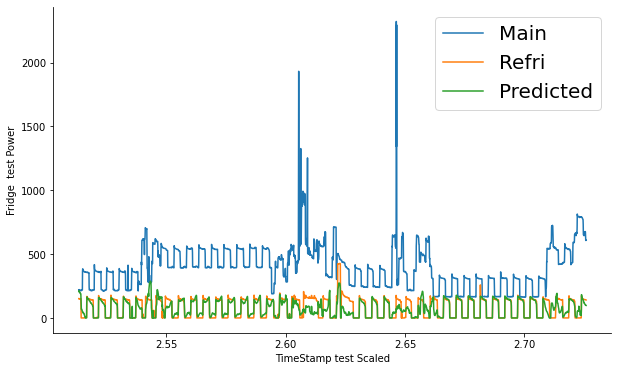

In [21]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_x.inverse_transform(xt[:,:99].cpu())[:idx,74], label = "Main")
plt.plot(x_test_timestamp[:idx], yt.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

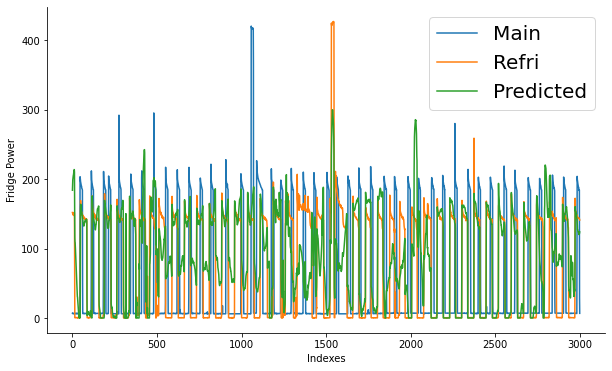

In [23]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), scaler_y.inverse_transform(y.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(jnp.arange(idx), yt.cpu()[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("Indexes")
plt.ylabel("Fridge Power")
sns.despine()

In [20]:
# plt.plot(np.array(test_timestamp_orig)[:300],np.array(yt)[:300])
# plt.plot(np.array(test_timestamp_orig)[:300],np.array(y_mean)[:300])

In [21]:
# plt.scatter(np.array(test_timestamp_orig)[:3000],np.array(y_mean)[:3000],label="True")
# plt.scatter(np.array(test_timestamp_orig)[:3000],np.array(yt)[:3000],label="Pred")
# plt.legend()
# plt.xlabel("TimeStamp")
# plt.xlabel("Refrogerator Power")

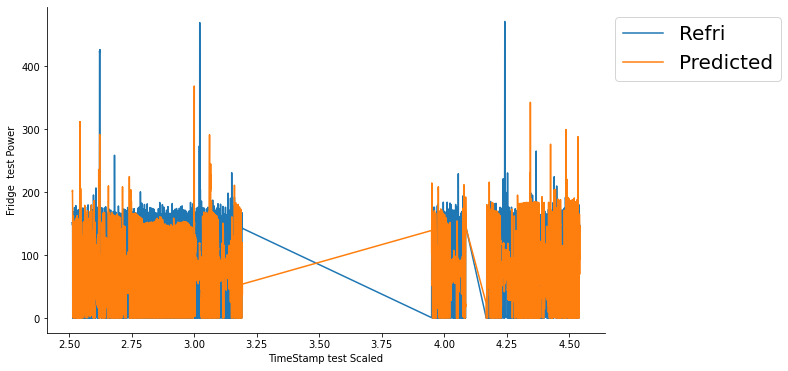

In [22]:
idx = x_test.shape[0]
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp, y_test[:idx], label = "Refri")
plt.plot(x_test_timestamp, y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()
# savefig("CombinationKernel")
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")

In [27]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [ ]:
pred_dist1 = model.predict(torch.tensor(np.array(x_train_full)).to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [ ]:
y_mean1 = scaler_y.inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_train.shape, y_mean1.shape)

In [ ]:
mae = np.mean(np.abs(np.array(y_train) - y_mean1))
rms = errors.rmse(jnp.array(y_train), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

In [ ]:
idx = x_train.shape[0]
plt.figure(figsize=(10,6))
plt.plot(x_train_timstamp, y_train[:idx], label = "Refri")
plt.plot(x_train_timstamp, y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()
# savefig("CombinationKernel")
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")

In [ ]:
#MAE:  39.81858310475401 build 6
#MAE:  30.333733374869247 build 3
#MAE:  37.32115756605644 build 2
#MAE: 43.212248588857065 build 5
#MAE:  48.917852990726765